## First Test to import tfrecords images from EE

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import pyrsgis
import cv2
from skimage.transform import resize
from PIL import Image
%matplotlib inline 
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

/Users/MaxBehrens/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/MaxBehrens/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/MaxBehrens/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/MaxBehrens/anaconda3/lib/python3.7/site-packages/tensorflow/

ImportError: dlopen(/Users/MaxBehrens/anaconda3/lib/python3.7/site-packages/osgeo/_gdal.cpython-37m-darwin.so, 2): Library not loaded: @rpath/libgif.7.dylib
  Referenced from: /Users/MaxBehrens/anaconda3/lib/libgdal.20.dylib
  Reason: image not found

In [ ]:
al01_2016_path = "/gdrive/My Drive/nuts_night/DE22_2012.tif"

ds1, featuresAL01 = pyrsgis.raster.read(al01_2016_path)

In [19]:
print("AL01 shape: ",featuresAL01.shape)
print(featuresAL01[:10,:10])

AL01 shape:  (3588, 8325)
[[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]


In [24]:
featuresAL01.shape[0]

3588

In [ ]:
# Reshape image to be a rectangle
raw_list = []
i_prev = 0

for i in range(0,featuresAL01.shape[0],2):
  if i != 0:
    raw_list.append(h_temp) 
  h_temp = None
  for k in range(0,featuresAL01.shape[1],5):
    if np.any(np.isnan(featuresAL01[i:i+2,k:k+5])) == False:
      if h_temp is None:
        h_temp = featuresAL01[i:i+2,k:k+5]
      else:
        h_temp = np.hstack((h_temp,featuresAL01[i:i+2,k:k+5]))
    else:
      pass

In [73]:
print(len(raw_list))

1793


In [64]:
featuresAL01[1:1+2,1:1+5]

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [35]:
al01_resized = resize(test, (2000,2000))

RuntimeError: ignored

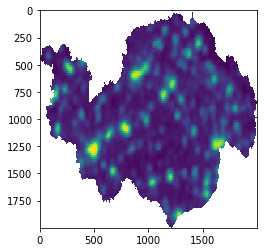

In [15]:
plt.imshow(al01_resized, interpolation='nearest')
plt.show()

In [17]:
al01_resized.shape

(2000, 2000)

In [ ]:
mypath = "/gdrive/My Drive/nuts_night/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [ ]:
# Reshape the image to have a rectangle shape


In [15]:
y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/nuts_gdp_cleaned.csv")
y_dat.head()

,region,year,value,code,country
0,BE,2008,33100.0,BE,Belgium
1,BE1,2008,61100.0,BE,Belgium
2,BE10,2008,61100.0,BE,Belgium
3,BE2,2008,33100.0,BE,Belgium
4,BE21,2008,39200.0,BE,Belgium


In [143]:
split1 = onlyfiles[0].rsplit('_',1)[0]
print(split1)
split2 = int(onlyfiles[0].rsplit('_',1)[1].rsplit('.',1)[0])
print(split2)

AL02
2012


In [17]:
y_dat.loc[(y_dat['region']==split1) & (y_dat['year']==split2),'value']

1607    3900.0
Name: value, dtype: float64

In [ ]:
def create_data(files,path, resolution = 256):
  x = []
  y = []
  label = []
  for f in files:
    ds, temp = pyrsgis.raster.read(str(path+f))
    #temp = temp.swapaxes(0,2)
    temp_resized = resize(temp, (resolution, resolution))
    x.append(temp_resized)
    split1 = f.rsplit('_',1)[0]
    split2 = int(f.rsplit('_',1)[1].rsplit('.',1)[0])
    y.append(y_dat.loc[(y_dat['region']==split1) & (y_dat['year']==split2),'value'])
    label.append(f)
  return x, y, label

In [ ]:
res = 32
x,y,label = create_data(onlyfiles,mypath, resolution=res)

In [116]:
print('Shape of x: ',len(x))
print('Shape of y: ',len(y))
print('Shape of labels: ', len(label))

Shape of x:  166
Shape of y:  166
Shape of labels:  166


## TO DO:



1.   Maybe adjust sampling method: First create rectangle shaped picture and the rescale
2.   Review literature, how they handled high res images
3.   Write function for correct train, validation and test split -> not the same locations in train and test




In [117]:
regions = []
for i in range(len(label)):
  regions.append(label[i].rsplit('_',1)[0])

regions = np.unique(regions)
print(len(regions))

83


In [118]:
msk = np.random.rand(len(regions)) < 0.7
train_split = regions[msk]
test_split = regions[~msk]
print(len(train_split))
print(len(test_split))

65
18


In [163]:
import math
label_train = []
label_test = []
x_train = []
y_train = []
x_test = []
y_test = []
for i in range(len(label)):
  if label[i].rsplit('_',1)[0] in train_split:
    if math.isnan(y[i]):
      pass
    else:
      label_train.append(label[i])
      x_train.append(x[i])
      y_train.append(int(y[i]))
  else:
    if math.isnan(y[i]):
      pass
    else:
      label_test.append(label[i])
      x_test.append(x[i])
      y_test.append(int(y[i]))
  
label_train = np.array(label_train)
label_test = np.array(label_test)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)  
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)

(106, 64, 64)
(24, 64, 64)
(24,)


In [164]:
x_train = np.array([x_train])
x_train = np.moveaxis(x_train,0,-1)
print(x_train.shape)
x_test = np.array([x_test])
x_test = np.moveaxis(x_test,0,-1)
print(x_test.shape)

(106, 64, 64, 1)
(24, 64, 64, 1)


In [ ]:
x_train = np.nan_to_num(x_train)
x_test = np.nan_to_num(x_test)

In [ ]:
# Standard Model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3, kernel_initializer='normal', input_shape=(64,64,1), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation = 'linear'))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [ ]:
# Data Augmentation
training_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2,
                                                                         zoom_range=0.2,
                                                                         horizontal_flip=True)
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()

In [ ]:
# Data Preparation
batch_size = 10

# Define the data flow
training_generator = training_data_generator.flow(x_train,y_train,batch_size=batch_size)
test_generator = test_data_generator.flow(x_test,y_test,batch_size=1,shuffle=False)

In [175]:
# Calculate the number of steps
training_steps = training_generator.n/batch_size

# Run the model
model.fit_generator(training_generator,
                    steps_per_epoch=training_steps,
                    epochs = 30,
                    verbose = 1
                   )

ResourceExhaustedError: ignored